In [ ]:
from datetime import datetime

instanteInicial = datetime.now()
print(instanteInicial)

2021-05-30 00:07:37.316130


# Activo la libreria de drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Instalación de librerias.

In [ ]:
!pip install tensorflow
!pip install tensorflow --upgrade

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.7/dist-packages (2.5.0)


# Importamos librerias.

In [ ]:
from glob import glob
import os
import PIL
import tensorflow as tf
from tensorflow import keras
import IPython.display as display
from matplotlib import pyplot as plt
import pandas as pd
import math
import numpy as np
from math import ceil

from platform import python_version

# Verificacion tecnica del sistema.

In [ ]:
print("Version de python: " + python_version())
print("Version de tensorflow: " + tf.__version__)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Seleccione el menú Tiempo de ejecución > "Cambiar tipo de tiempo de ejecución" para activar un acelerador de GPU, ')
  print('y luego volver a ejecutar esta celda.')
else:
  print(gpu_info)

Version de python: 3.7.10
Version de tensorflow: 2.5.0
Sun May 30 00:07:48 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                 

# Funciones utiles para hacer conversiones.

In [ ]:
# Las siguientes funciones se pueden utilizar para convertir un valor en un tipo compatible
# con tf.train.Example.

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy() # BytesList no desempaquetará una cadena de un EagerTensor.
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    """Returns an int64_list from a bool / enum / int / uint."""
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

# Creamos la función para el diccionario con las caracteristicas que necesitamos.

In [ ]:
def image_example(image_string, label):
    feature = {
        'label': _int64_feature(label),
        'image_raw': _bytes_feature(image_string),
    }
    
    return tf.train.Example(features=tf.train.Features(feature=feature))

def image_example_test(image_string):
    feature = {
        'image_raw': _bytes_feature(image_string),
    }
    
    return tf.train.Example(features=tf.train.Features(feature=feature))

# Se realiza el siguiente procedimiento:
    1. Creamos el directorio "content", en el va estar los archivos tfrecord correspondiente a cada dataset.
    2. Encontramos los nombres de las rutas para el record_file ejemplo:
    
        ['dataset-mineria-test-labels',
         'dataset-mineria-test-bounds',
         'dataset-mineria-test-rgb',
         'dataset-mineria-test-nir',
         'dataset-mineria-test-masks',
         'dataset-mineria-train-labels',
         'dataset-mineria-train-bounds',
         'dataset-mineria-train-rgb',
         'dataset-mineria-train-nir',
         'dataset-mineria-train-masks']
         
    3. Escribimos los archivos de imagen en bruto en `images.tfrecords`.
    4. Se obtienen la dupla imagenes y categorias.
    5. Utilizamos la función `image_example` para agregarlos al diccionario en formato tf.train.Features envuelto en el formato tf.train.example.
    6. Agregamos la información al archivo `images.tfrecords`.

In [ ]:
if not os.path.exists('content'):
    os.makedirs('content')
    
def crearTfrecord(pathDataset):
    
    pathContenDataset = glob(pathDataset + "/*")

    pathContenDatasets = []

    for _idx, _valor in enumerate(pathContenDataset):
        path = glob(_valor + "/*")
        pathContenDatasets.append(path)

    pathContenDatasets_ = []
    for _idx, _valor in enumerate(pathContenDatasets):
        for __idx, __valor in enumerate(_valor):
            pathContenDatasets_.append(__valor)

    for _idx, _valor in enumerate(pathContenDatasets_):
        path = _valor
        pathString = path.replace("/", "-")
        record_file = 'content/{}.tfrecords'.format(pathString)
        classes = os.listdir(path)
        with tf.io.TFRecordWriter(record_file, ) as writer:
            archivoImg = glob(path + '/*/*')
            for _idx, filename in enumerate(archivoImg):
                image_string = open(filename, 'rb').read()
                category = filename.split('/')[3]
                label = classes.index(category)
                tf_example = image_example(image_string, label)
                writer.write(tf_example.SerializeToString())

In [ ]:
record_file = '/content/drive/MyDrive/AgricultureVisión/Data/test/test.tfrecords'
path = '/content/drive/MyDrive/AgricultureVisión/Data/dataset-estadistica/test/rgb'

with tf.io.TFRecordWriter(record_file, ) as writer:
            archivoImg = glob(path + '/*/*')
            for _idx, filename in enumerate(archivoImg):
                image_string = open(filename, 'rb').read()
                tf_example = image_example_test(image_string)
                writer.write(tf_example.SerializeToString())

# Ejecutamos la función crearTfrecord.

In [ ]:
crearTfrecord('dataset-mineria/')

In [ ]:
ls content/*.tfrecords

content/dataset-estadistica-test-bounds.tfrecords
content/dataset-estadistica-test-labels.tfrecords
content/dataset-estadistica-test-masks.tfrecords
content/dataset-estadistica-test-nir.tfrecords
content/dataset-estadistica-test-rgb.tfrecords
content/dataset-estadistica-train-bounds.tfrecords
content/dataset-estadistica-train-labels.tfrecords
content/dataset-estadistica-train-masks.tfrecords
content/dataset-estadistica-train-nir.tfrecords
content/dataset-estadistica-train-rgb.tfrecords


# En el caso que el tfrecord es demasiado pesado lo que dice la literatura seria partilo en pedados entre 10 a 100 mb.

### "Nota: En general, debería repartir sus datos entre varios archivos para poder paralelizar la E/S (dentro de un único host o entre varios hosts). La regla general es tener al menos 10 veces más archivos que hosts leyendo datos. Al mismo tiempo, cada archivo debe ser lo suficientemente grande (al menos 10+MB e idealmente 100MB+) para que te beneficies de la precarga de E/S. Por ejemplo, digamos que tienes X GBs de datos y planeas entrenar en hasta N hosts. Idealmente, deberías dividir los datos en ~10*N archivos, siempre y cuando ~X/(10*N) sea 10+ MBs (e idealmente 100+ MBs). Si es menos que eso, puede que necesites crear menos fragmentos para compensar los beneficios del paralelismo y los beneficios de la precarga de E/S" 

link (https://www.tensorflow.org/api_docs/python/tf/data/TFRecordDataset)

# Creamos los directorios donde se van a guardar los tfrecord particionados dependiendo del peso total del original, despues hago las particiones.

In [ ]:
def crearDirectoriosTfrecord(path):
    
    filesTfrecords = glob(path)

    # creo ruta data donde van a quedar las particiones.
    directorioData = "content/data"

    if not os.path.exists(directorioData):
        os.makedirs(directorioData)

    for _idx, _valor in enumerate(filesTfrecords):
        ruta = _valor.split(".")[0]
        rutaFinal = ruta.replace("/", "/data/")
        if not os.path.exists(rutaFinal):
            os.makedirs(rutaFinal)
            

def particionesTfrecord(partesMbytes, path):

    filesTfrecords = glob(path)

    for _idx, _valor in enumerate(filesTfrecords):
        file = _valor
        pesoTfrecord = os.stat('{}'.format(file)).st_size / (1024 * 1024)

        raw_dataset = tf.data.TFRecordDataset(file)

        pathTfrecordOut = file.split(".")[0].replace("/", "/data/")
        nameFile = file.split("/")[1]

        shards = ceil(pesoTfrecord / partesMbytes)

        for i in range(shards):
            writer = tf.data.experimental.TFRecordWriter(f"{pathTfrecordOut}/{nameFile}-part-{i}.tfrecords")
            writer.write(raw_dataset.shard(shards, i))

In [ ]:
crearDirectoriosTfrecord("content/*.tfrecords")
particionesTfrecord(80, "content/*.tfrecords")

In [ ]:
instantefinal = datetime.now()
duracion = instantefinal - instanteInicial
print("Duración: ", duracion)

Duración:  0:02:38.085495


# lectura del archivo `images.tfrecords` creado cuando estan rebanados.

In [ ]:
path = 'content/data/dataset-estadistica-test-nir/'
train_filenames=(glob(path+'*.tfrecords'))
train_filenames

['content/data/dataset-estadistica-test-nir/dataset-estadistica-test-nir.tfrecords-part-0.tfrecords']

In [ ]:
pathClases = 'dataset-estadistica/test/rgb'
classes = os.listdir(pathClases)

aux = []
for _idx, _valor in enumerate(classes):
    Class = _valor
    label = (classes.index(_valor))
    aux.append([Class, label])
    
csv = pd.DataFrame(aux, columns=['Class','label'])


In [ ]:
csv.head(10)

,Class,label
0,storm_damage,0
1,drydown,1
2,endrow,2
3,water,3
4,nutrient_deficiency,4
5,double_plant,5
6,waterway,6
7,weed_cluster,7
8,planter_skip,8


In [ ]:
#Tamaño de las imágenes en los archivos TFRecord
IMAGE_SIZE=[512,512]
CLASSES=list(csv['Class'])
print(CLASSES)
NO_OF_CLASSES=len(CLASSES)
NO_OF_CLASSES

['storm_damage', 'drydown', 'endrow', 'water', 'nutrient_deficiency', 'double_plant', 'waterway', 'weed_cluster', 'planter_skip']


9

In [ ]:
#Crear tf.data.Dataset a partir de archivos TFRecord
AUTO = tf.data.experimental.AUTOTUNE
ignore_order = tf.data.Options()
ignore_order.experimental_deterministic = False

def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convertir la imagen en flotantes en el rango [0, 1]
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # tamaño explícito necesario para el TPU
    return image

def read_tfrecord(example):
    features={
            "image_raw": tf.io.FixedLenFeature([], tf.string),
            "label": tf.io.FixedLenFeature([], tf.int64),}
    example = tf.io.parse_single_example(example, features)
    image = decode_image(example['image_raw'])
    label = tf.cast(example['label'], tf.int32)
    return image, label

def load_dataset(filenames,shuffle,BATCH_SIZE,repeat=False):
    # Leer desde TFRecords. Para un rendimiento óptimo, lea de varios
    # Archivos TFRecord a la vez y establecer la opción experimental_deterministic = False
    # para permitir optimizaciones que alteren el orden.
    dataset = tf.data.TFRecordDataset(filenames,num_parallel_reads=AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord)
    dataset = dataset.prefetch(AUTO)
    dataset = dataset.shuffle(shuffle)
    if(repeat):
        dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    return dataset

def display_batch_of_images(databatch, predictions=None):
    """Esto funcionará con:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-cuadrado: esto eliminará los datos que no encajen en un cuadrado o rectángulo.
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # tamaño y espaciado
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # mostrar
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # fórmula mágica probada para trabajar de 1x1 a 10x10 imágenes
        subplot = display_one(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #diseño
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # cadena binaria en este caso, se trata de cadenas de identificación de imágenes.
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # Si no hay etiquetas, sólo los ID de las imágenes, devuelve None para las etiquetas (este es el caso de los datos de prueba)
    return numpy_images, numpy_labels

def display_one(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)

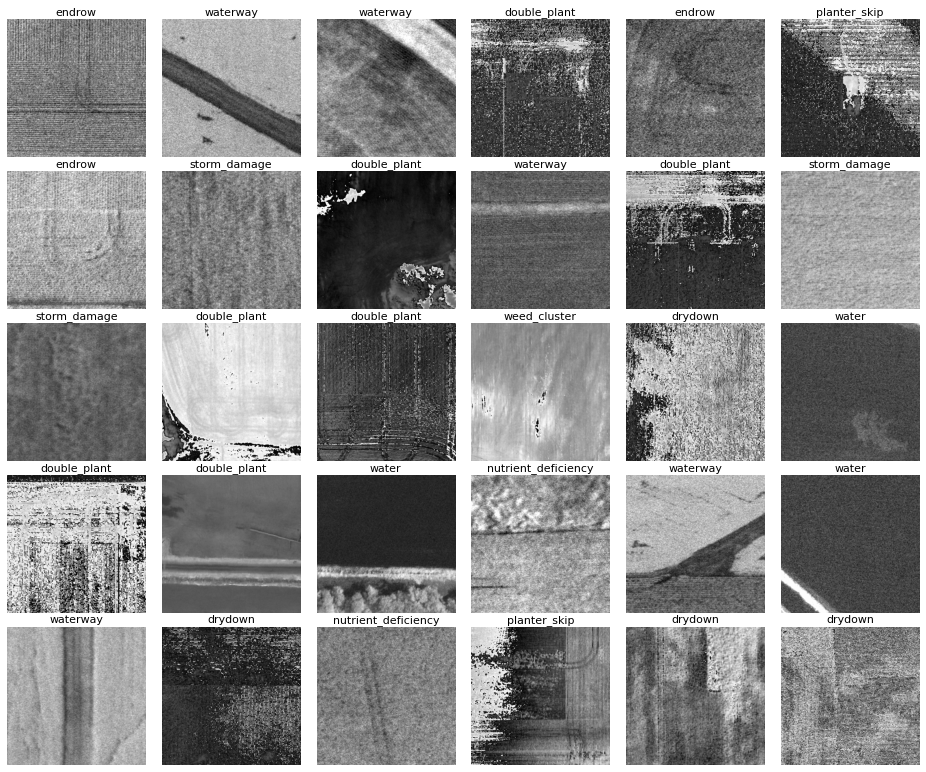

In [ ]:
#Mostrar algunas imágenes del conjunto de datos de entrenamiento.
d=load_dataset(train_filenames,5000,30)
train_batch=iter(d)
display_batch_of_images(next(train_batch))